In [1]:
from google.colab import files
uploaded = files.upload()

Saving CCPP_data.csv to CCPP_data.csv


In [2]:
import io
import pandas as pd
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

In [3]:
print("Shape:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nFirst 5 rows:")
display(df.head())

Shape: (9568, 5)

Column types:
 AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object

First 5 rows:


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
print("\nSummary statistics:")
display(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())


Summary statistics:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000



Missing values per column:
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


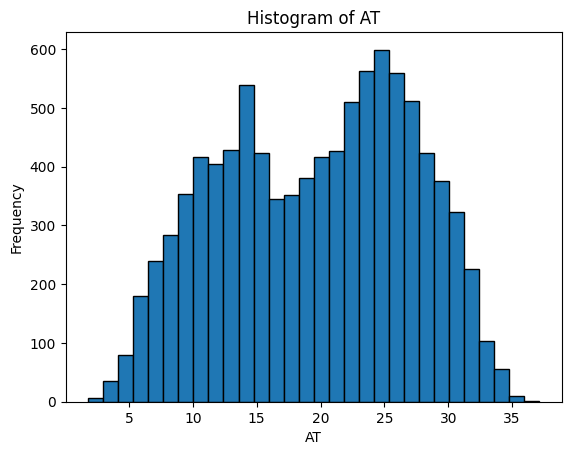

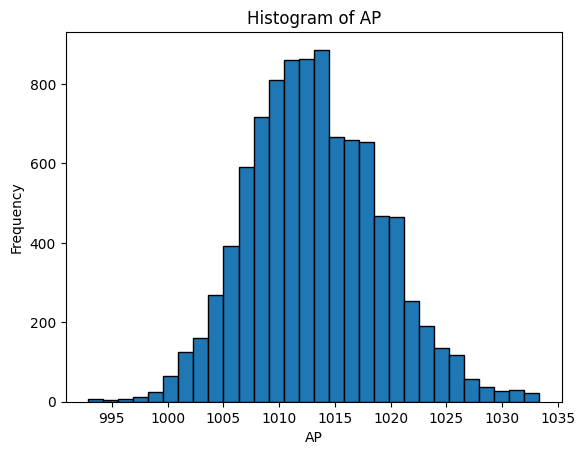

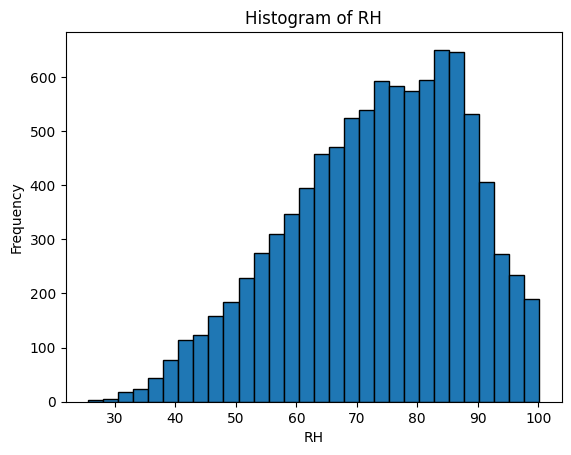

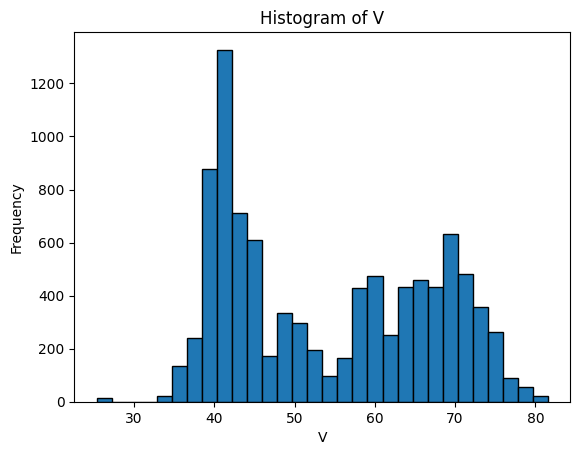

In [5]:
import matplotlib.pyplot as plt

features = ['AT', 'AP', 'RH', 'V']

for feat in features:
    plt.figure()
    plt.hist(df[feat], bins=30, edgecolor='black')
    plt.title(f'Histogram of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()

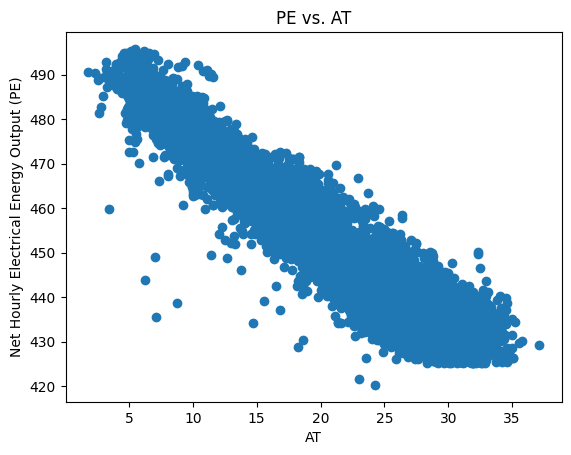

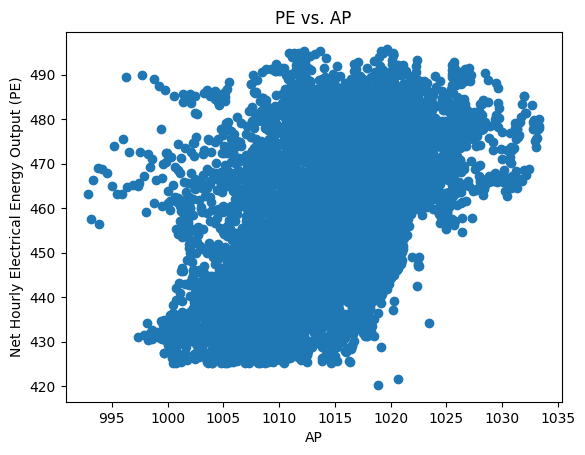

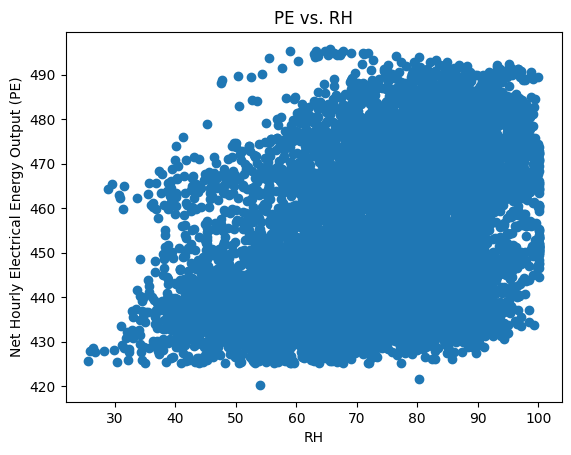

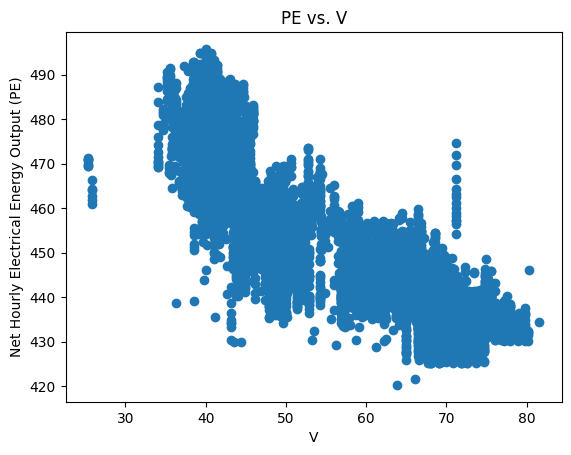

In [6]:
for feat in features:
    plt.figure()
    plt.scatter(df[feat], df['PE'])
    plt.title(f'PE vs. {feat}')
    plt.xlabel(feat)
    plt.ylabel('Net Hourly Electrical Energy Output (PE)')
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [8]:
features = ['AT', 'AP', 'RH', 'V']
X = df[features]
y = df['PE']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (7654, 4) Test: (1914, 4)


In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
lr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lr',   LinearRegression())
])
lr_scores = cross_val_score(
    lr_pipe, X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=kf
)
lr_rmse = np.sqrt(-lr_scores)
print(f"Linear Regression CV RMSE: {lr_rmse.mean():.3f} ± {lr_rmse.std():.3f}")

Linear Regression CV RMSE: 4.572 ± 0.080


In [12]:
rf_pipe = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
])
rf_scores = cross_val_score(
    rf_pipe, X_train, y_train,
    scoring='neg_mean_squared_error',
    cv=kf
)
rf_rmse = np.sqrt(-rf_scores)
print(f"Random Forest CV RMSE:   {rf_rmse.mean():.3f} ± {rf_rmse.std():.3f}")

Random Forest CV RMSE:   3.462 ± 0.152


In [13]:
from sklearn.metrics import mean_squared_error, r2_score

rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

test_r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse:.3f} MW")
print(f"Test R²:   {test_r2:.3f}")

Test RMSE: 3.244 MW
Test R²:   0.964


Feature importances:
AT    0.900747
V     0.062768
AP    0.018344
RH    0.018141
dtype: float64


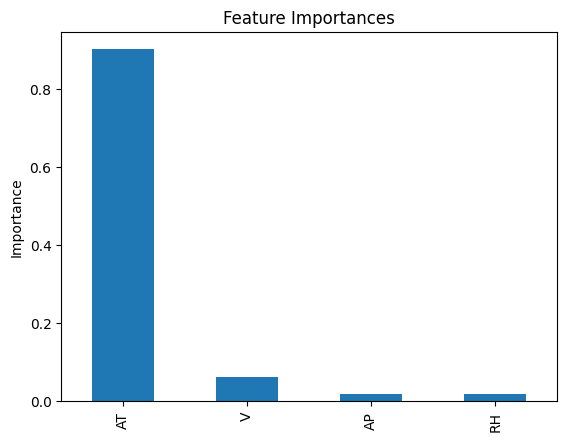

In [14]:
importances = rf_pipe.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

print("Feature importances:")
print(feat_imp)

feat_imp.plot.bar(title="Feature Importances"); plt.ylabel("Importance"); plt.show()